# Recurrent learning of patterns via RNN

After we have taken a first look at fully connected neural networks we now want to take a look at recurrent neural networks, RNN.
This architecture employs a feedback mechanism into the network where a previous state of a series can be analyzed and stored.
This not just allows to provide an arbitrary number of samples as context input but also.

One could think this as some kind of delay line that is analyzing past events and can provide context on how to interpret the current sample.

```{figure} https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg

A picture of an RNN, "unrolled" in time on the right side.

$x$ is an input vector with $n \times t$ dimensions, where $n$ is the number of input features and $t$ the number of time steps.
$U$, $V$ and $W$ are weights.
The hidden layer $h_t$ takes as input $x_t$ and the state of the previous hidden state $h_{t-1}$ and generates an output $o_t$.

Source: https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg
```

We will start by simply trying, like previously, to predict the next note to get a bit familiar with the structure of an RNN.

In [ ]:
import lightning as L
import numpy as np
import torch
import torch.nn as nn


class SimpleRNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=88,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
        )
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(
            in_features=256,
            out_features=88,
        )
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x: torch.Tensor):
        # x must have shape (batch_size, time_steps, features)
        z, _ = self.rnn(x)
        z = self.dropout(z)
        # only take the "latest" output from our time dimension
        z = z[:, -1, :]
        z = self.fc(z)
        return z

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, torch.argmax(y, dim=1))
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


simple_rnn = SimpleRNN()

# add gradient clipping to avoid exploding gradients
CLIP_VALUE = 10.0
for p in simple_rnn.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -CLIP_VALUE, CLIP_VALUE))

print(simple_rnn)

SimpleRNN(
  (rnn): LSTM(88, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=88, bias=True)
  (criterion): CrossEntropyLoss()
)


In [ ]:
from pytorch_lightning.utilities.model_summary import ModelSummary

ModelSummary(model=simple_rnn)

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | rnn       | LSTM             | 880 K  | train
1 | dropout   | Dropout          | 0      | train
2 | fc        | Linear           | 22.6 K | train
3 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
903 K     Trainable params
0         Non-trainable params
903 K     Total params
3.613     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode

Once again, we need to tweak our data loading mechanism to account for the new ways of our network.

In [ ]:
import pandas as pd
from ki_ueben.datasets import Maestro3Dataset
from ki_ueben.midi import PianoRoll
from tqdm import tqdm

note_dfs = []
maestro_files = Maestro3Dataset()

# limit files - set to -1 for no limits
NUM_FILES = 60

for midi_path in tqdm(maestro_files[:NUM_FILES]["file_path"]):
    piano_roll = PianoRoll(midi_path)
    df_events = piano_roll.events()
    # filter out pedal (note=-1) and note_off events (velocity=0)
    df_events = df_events[(df_events["note"] > 0) & (df_events["velocity"] > 0)]
    df_events["note"]
    note_dfs.append(df_events)

simple_df = pd.concat(note_dfs)
simple_df

100%|██████████| 60/60 [00:31<00:00,  1.88it/s]


,note,velocity,time
1,37,25,0.437500
2,49,30,0.959635
3,40,47,1.342448
6,37,31,1.725260
8,49,23,2.100260
...,...,...,...
7460,50,26,210.647135
7462,38,31,210.651042
7530,69,29,212.897135
7531,74,40,212.901042


In [ ]:
from torch.utils.data.dataset import TensorDataset

# number of notes as context for network
CONTEXT_NUM_NOTES = 100

# -21 to scale data down to 0
one_hot_data = np.eye(88)[simple_df["note"].values - 21]

# offset the data by 1 between X and y
probability_data_X = one_hot_data[:-1]
probability_data_y = one_hot_data[1:]

context_X = []
context_y = []

# not efficient, but works
for i in range(one_hot_data.shape[0] - CONTEXT_NUM_NOTES):
    context_X.append(one_hot_data[i : i + CONTEXT_NUM_NOTES])
    context_y.append(one_hot_data[i + CONTEXT_NUM_NOTES])

context_X = np.array(context_X, dtype=bool)
context_y = np.array(context_y, dtype=bool)

context_dataset = TensorDataset(
    torch.from_numpy(context_X).to(dtype=torch.float32),
    torch.from_numpy(context_y).to(dtype=torch.float32),
)

print(f"context_X: {context_X.shape}, context_y: {context_y.shape}")

context_X: (544142, 100, 88), context_y: (544142, 88)


In [ ]:
import os

os.path.isfile("logs/simple_rnn/version_0/model_2024.ckpt")

True

In [ ]:
import os

from pytorch_lightning.loggers import CSVLogger

MODEL_PATH = "logs/simple_rnn/version_0/model_2024.ckpt"

if not os.path.isfile(MODEL_PATH):
    print("Start training - this will take a while")
    rnn_loader = torch.utils.data.DataLoader(
        dataset=context_dataset, batch_size=64, num_workers=4, persistent_workers=True
    )

    rnn_trainer = L.Trainer(
        max_epochs=100,
        logger=[
            # we store the metrics into a CSV file so we can take a look at its progress later
            CSVLogger(save_dir="logs", name="simple_rnn", version=0)
        ],
    )

    rnn_trainer.fit(model=simple_rnn, train_dataloaders=rnn_loader)
    rnn_trainer.save_checkpoint(MODEL_PATH)
else:
    print("Found model - will load model")

eval_model = simple_rnn.load_from_checkpoint(MODEL_PATH)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/simple_rnn/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory logs/simple_rnn/version_0/checkpoints exists and is not empty.
LOCAL_RANK: 0

Epoch 99: 100%|██████████| 8503/8503 [01:25<00:00, 99.49it/s, v_num=0, train_loss=0.182] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 8503/8503 [01:25<00:00, 99.46it/s, v_num=0, train_loss=0.182]


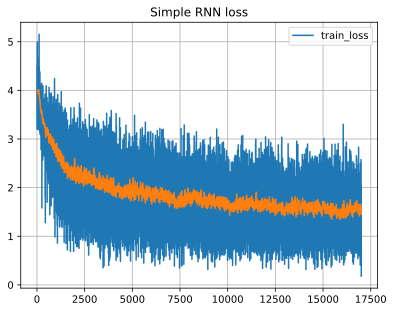

In [ ]:
import pandas as pd

%config InlineBackend.figure_format = 'svg'

df_simple_metrics = pd.read_csv("logs/simple_rnn/version_0/metrics.csv")
df_simple_metrics.plot.line(
    grid=True,
    title="Simple RNN loss",
    # x="step",
    y="train_loss",
)
df_simple_metrics["train_loss"].rolling(40).mean().plot.line(
    grid=True, label="Meaned train_loss"
);

The training of this network already took nearly 3 hours on a GPU, but it shows some progress in regards to its training loss.


```{admonition} Note
Instead of using an [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) cell, I also tried out experiments with a plain [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) cell, but this did not converge over time.
So it seems that RNN can't maintain enough memory for our task.
I also increased the context we provide to the RNN from 40 to 100 - but this also increases our memory demand by a lot!

```{figure} assets/rnn-loss.svg

The RNN setup did not converge as seen in this loss plot.
```
```

It seems we are moving in a right direction here as we start to make some actually learning progress, but our model still lacks crucial elements such as timing, velocity and sustain, therefore we need to implement a different kind of data representation which accounts for all these kinds.
Yet we already run out of memory capacity, because we load all data into memory at once.
Therefore we have to go yet another step, in which we stream data into the neural network instead of having our whole dataset in memory at once.
We will also take all our other parameters into account.

If you are interested in RNNs, consider reading some [tutorials from the PyTorch docs](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

```{admonition} Task
* Evaluate the model by trying out some input samples - how does it compare to our previous models?
* What is the dropout layer doing?
* Why does this take so long to train? What could be ways of reducing its training time with or without sacrificing quality?
```